下記のモジュールをインストールをしておく
 * pyaudio
 * matplotlib

# 音声の録音・再生
参考：http://hanpakousaku.tumblr.com/post/105771613672/raspberrypi-%E3%81%A8-pyaudio%E3%81%A7%E9%8C%B2%E9%9F%B3%E9%9F%B3%E5%A3%B0%E6%B3%A2%E5%BD%A2%E5%87%A6%E7%90%86
参考：https://people.csail.mit.edu/hubert/pyaudio/

## 録音

In [1]:
import pyaudio
import sys
import time
import wave

In [2]:
# recording parameter
CHUNK = 1024
FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE = 44100
input_device_index = 0

In [3]:
#RECORD_SECONDS = input('Please input recoding time>>>')
RECORD_SECONDS = 10

In [4]:
p = pyaudio.PyAudio()

In [10]:
#マイクからデータ取得
stream = p.open(format = FORMAT,
                channels = CHANNELS,
                rate = RATE,
                input = True,
                frames_per_buffer = CHUNK)

In [11]:
all = []
for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
    data = stream.read(CHUNK)
    all.append(data)

In [12]:
data = b''.join(all)                    
out = wave.open('test.wav','wb')
out.setnchannels(1) #mono
out.setsampwidth(2) #16bits
out.setframerate(RATE)
out.writeframes(data)
out.close()

## 再生

In [13]:
wf = wave.open("test.wav", 'rb')
stream = p.open(format=p.get_format_from_width(wf.getsampwidth()),
                channels=wf.getnchannels(),
                rate=wf.getframerate(),
                output=True)

In [14]:
data = wf.readframes(CHUNK)

In [15]:
# ※止まらない
while data != '':
    stream.write(data)          # ストリームへの書き込み(バイナリ)
    data = wf.readframes(CHUNK) # ファイルから1024個*2個の

KeyboardInterrupt: 

In [16]:
stream.stop_stream()
stream.close()

# 波形を見る
参考:http://aidiary.hatenablog.com/entry/20110519/1305808715

In [17]:
from numpy import frombuffer
import matplotlib.pyplot as plt
%matplotlib inline

In [18]:
def printWaveInfo(wf):
    """WAVEファイルの情報を取得"""
    print ("チャンネル数:", wf.getnchannels())
    print ("サンプル幅:", wf.getsampwidth())
    print ("サンプリング周波数:", wf.getframerate())
    print ("フレーム数:", wf.getnframes())
    print ("パラメータ:", wf.getparams())
    print ("長さ（秒）:", float(wf.getnframes()) / wf.getframerate())

In [19]:
wf = wave.open("test.wav", "r")

In [20]:
printWaveInfo(wf)

チャンネル数: 1
サンプル幅: 2
サンプリング周波数: 44100
フレーム数: 440320
パラメータ: _wave_params(nchannels=1, sampwidth=2, framerate=44100, nframes=440320, comptype='NONE', compname='not compressed')
長さ（秒）: 9.984580498866213


In [21]:
buffer = wf.readframes(wf.getnframes())

In [22]:
print(len(buffer))

880640


In [23]:
data = frombuffer(buffer, dtype="int16")

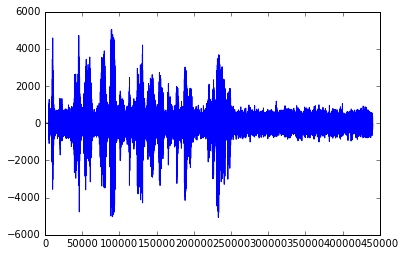

In [26]:
plt.plot(data)
plt.show()

# 高速フーリエ変換でスペクトル解析
参考：http://aidiary.hatenablog.com/entry/20110618/1308367728

In [27]:
import numpy as np
import scipy.fftpack

In [28]:
wf = wave.open("test.wav" , "r" )
fs = wf.getframerate()  # サンプリング周波数
x = wf.readframes(wf.getnframes())
x = frombuffer(x, dtype= "int16") / 32768.0  # -1 - +1に正規化
wf.close()

In [29]:
start = 40000  # サンプリングする開始位置
N = 4096    # FFTのサンプル数

In [30]:
# FFT
X = np.fft.fft(x[start:start+N])
#X = scipy.fftpack.fft(x[start:start+N]) # scipy版

# 周波数軸の値の計算
freqList = np.fft.fftfreq(N, d=1.0/fs)
#freqList = scipy.fftpack.fftfreq(N, d=1.0/ fs)  # scipy版

In [31]:
amplitudeSpectrum = [np.sqrt(c.real ** 2 + c.imag ** 2) for c in X]  # 振幅スペクトル
phaseSpectrum = [np.arctan2(int(c.imag), int(c.real)) for c in X]    # 位相スペクトル

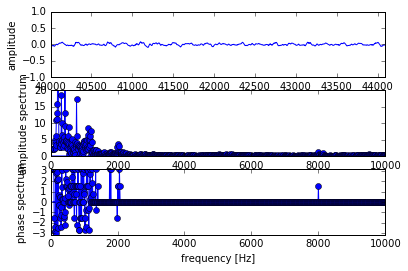

In [32]:
# 波形の描画
plt.subplot(311)
plt.plot(range(start, start+N), x[start:start+N])
plt.axis([start, start+N, -1.0, 1.0])
plt.xlabel("time [sample]")
plt.ylabel("amplitude")

# 振幅スペクトルを描画
plt.subplot(312)
plt.plot(freqList, amplitudeSpectrum, marker= 'o', linestyle='-')
plt.axis([0, 10000, 0, 20])
plt.xlabel("frequency [Hz]")
plt.ylabel("amplitude spectrum")

# 位相スペクトルを描画
plt.subplot(313)
plt.plot(freqList, phaseSpectrum, marker= 'o', linestyle='-')
plt.axis([0, 10000, -np.pi, np.pi])
plt.xlabel("frequency [Hz]")
plt.ylabel("phase spectrum")

plt.show()

# スペクトログラムの描画
参考：http://aidiary.hatenablog.com/entry/20111001/1317441171

In [33]:
# WAVEファイルから波形データを取得
wf = wave.open("test.wav", "rb")
data = wf.readframes(wf.getnframes())
data = frombuffer(data, dtype="int16")
length = float(wf.getnframes()) / wf.getframerate()  # 波形長さ（秒）

In [34]:
# FFTのサンプル数
N = 512

In [35]:
# FFTで用いるハミング窓
hamming_window = np.hamming(N)

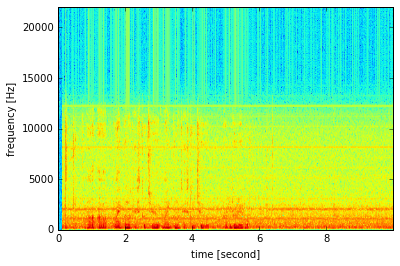

In [36]:
# スペクトログラムの描画
pxx, freqs, bins, im = plt.specgram(data, NFFT=N, Fs=wf.getframerate(), noverlap=0, window=hamming_window)
plt.axis([0, length, 0, wf.getframerate() / 2])
plt.xlabel("time [second]")
plt.ylabel("frequency [Hz]")

plt.show()